# Assignment 3: Regression & Ensembles

In [219]:
# enter your name and UFL email address
name = 'Kamal Sai Raj Kuncha'
email = 'k.kuncha@ufl.edu'

In [220]:
if name == 'enter your name' or email == 'enter your email':
    assert False, 'Enter your name & email first!'
else:
    print('Assignment 3 -- name: {}, email: {}\n'.format(name, email))
    
    # Load packages we need
    import sys
    import os
    import time

    import numpy as np
    import pandas as pd
    import sklearn

    from matplotlib import pyplot as plt
    plt.rcParams.update({'font.size': 16})

    # Let's check our software versions
    print('### Python version: ' + __import__('sys').version)
    print('### NumPy version: ' + np.__version__)
    print('### Scikit-learn version: ' + sklearn.__version__)
    print('------------')


    # load our packages / code
    sys.path.insert(1, '../common/')
    import utils
    import plots

Assignment 3 -- name: Kamal Sai Raj Kuncha, email: k.kuncha@ufl.edu

### Python version: 3.6.5 (v3.6.5:f59c0932b4, Mar 28 2018, 17:00:18) [MSC v.1900 64 bit (AMD64)]
### NumPy version: 1.19.5
### Scikit-learn version: 0.24.0
------------


In [221]:
# global parameters to control behavior of the pre-processing, ML, analysis, etc.
seed = 42

# deterministic seed for reproducibility
##rng = np.random.default_rng(seed)  # best practice but not fully implemented in scikit-learn
np.random.seed(seed)

prop_vec = [14, 3, 3]

## Part 1: Loading and Pre-processing Data

### For this assignment we'll load the Bike Sharing dataset (hourly)
### This dataset contains features of users bike sharing/rental on an hourly basis.
### The task is to predict how many users are sharing/renting a bike.

### Loading data

In [222]:
### Note: this dataset has missing values (artificially introduced), which you'll need to fill in before you can train a model
df = pd.read_csv('../data/bikesharehour.csv.gz', compression='gzip', header=0, na_values='?')

# Check that we loaded the data as expected
df_expected_shape = (17379, 15)

assert df.shape == df_expected_shape, 'Unexpected shape of df!'

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      16320 non-null  float64
 1   year        16231 non-null  float64
 2   month       16304 non-null  float64
 3   hour        16254 non-null  float64
 4   holiday     16277 non-null  float64
 5   weekday     16282 non-null  float64
 6   workingday  16297 non-null  float64
 7   weathersit  16324 non-null  float64
 8   temp        16242 non-null  float64
 9   atemp       16271 non-null  float64
 10  hum         16252 non-null  float64
 11  windspeed   16281 non-null  float64
 12  registered  16244 non-null  float64
 13  nsqrtc      16263 non-null  float64
 14  count       17379 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 2.0 MB


In [223]:
## what does the data look like?
df.head()

,season,year,month,hour,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,registered,nsqrtc,count
0,1.0,0.0,NaN,0.0,0.0,6.0,0.0,1.0,NaN,0.0,0.0,0.0,13.0,-5.0,16
1,1.0,0.0,NaN,1.0,0.0,6.0,0.0,1.0,NaN,0.0,0.0,0.0,32.0,-8.0,40
2,1.0,0.0,1.0,2.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,27.0,-7.0,32
3,1.0,0.0,1.0,3.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,10.0,-5.0,13
4,1.0,0.0,1.0,4.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1


### There are some NaNs which we'll have to impute!

In [224]:
# grab all the data as a numpy matrix
all_xy = df.to_numpy()

col_names = [c for c in df.columns]
features = col_names[:-1]
target = col_names[-1]

In [225]:
print('features: {} --- target: {}'.format(features, target))

features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'registered', 'nsqrtc'] --- target: count


In [226]:
# how many NaNs in each column?
np.sum(np.isnan(all_xy), axis=0)

array([1059, 1148, 1075, 1125, 1102, 1097, 1082, 1055, 1137, 1108, 1127,
       1098, 1135, 1116,    0])

### Observe: no NaNs in the target/value column
### About 1000+ NaNs in each feature

In [227]:
# split into x and y
all_x_nan = all_xy[:,:-1]
all_y = all_xy[:,-1]
print(all_x_nan)

[[ 1.000  0.000  nan ...  0.000  13.000 -5.000]
 [ 1.000  0.000  nan ...  0.000  32.000 -8.000]
 [ 1.000  0.000  1.000 ...  0.000  27.000 -7.000]
 ...
 [ 1.000  1.000  12.000 ...  3.000  83.000 -8.000]
 [ nan  1.000  12.000 ...  2.000  48.000 -11.000]
 [ 1.000  1.000  12.000 ...  2.000  37.000  nan]]


## [Task 1] (10 points) Let's impute the missing values! Use Scikit-learn's SimpleImputer to replace all NaNs in 'all_x_nan' with the *most frequent* value in each column. Use copy=True and store the results in 'all_x' 

In [228]:
from sklearn.impute import SimpleImputer

###* put your code here (~2-3 lines) *###
imputer=SimpleImputer(missing_values=np.nan,strategy="most_frequent",copy=True)
imputer.fit(all_x_nan)
all_x=imputer.transform(all_x_nan)
print(all_x)

[[ 1.000  0.000  7.000 ...  0.000  13.000 -5.000]
 [ 1.000  0.000  7.000 ...  0.000  32.000 -8.000]
 [ 1.000  0.000  1.000 ...  0.000  27.000 -7.000]
 ...
 [ 1.000  1.000  12.000 ...  3.000  83.000 -8.000]
 [ 3.000  1.000  12.000 ...  2.000  48.000 -11.000]
 [ 1.000  1.000  12.000 ...  2.000  37.000  0.000]]


In [229]:
# check that the shape is correct
assert all_x.shape == (17379, 14)

# check that there are no more NaNs
assert np.sum(np.sum(np.isnan(all_x), axis=0)) == 0

### Rescale the features

In [230]:
# We'll min-max normalize the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(copy=True)
scaler.fit(all_x) 

scaled_all_x = scaler.transform(all_x)

### Let's split the data

In [231]:
# split the data into train, test, val
train_x, train_y, test_x, test_y, val_x, val_y = utils.train_test_val_split(scaled_all_x, all_y, prop_vec, shuffle=True, seed=seed)

# sanity check shapes
train_x.shape, train_y.shape, test_x.shape, test_y.shape, val_x.shape, val_y.shape

((12166, 14), (12166,), (2607, 14), (2607,), (2606, 14), (2606,))

## [Task 2] (30 points) Let's train linear models!

### [Task 2a] (2 points) Train a Linear Regression model using the default hyperparameters. 

In [232]:
from sklearn.linear_model import LinearRegression

### Train a linear regression model on the training data (train_x, train_y)
### Call the resulting trained model 'lrmodel'
###* put your code here (~1 line) *###
lrmodel=LinearRegression()
lrmodel.fit(train_x,train_y)


LinearRegression()

In [233]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def r2_mse_mae_eval(model, pref=''):
    # R^2 the coefficient of determination
    r2_train = model.score(train_x, train_y)
    r2_val = model.score(val_x, val_y)

    print('{}Train R^2: {:.3f}, Val  R^2: {:.3f}'.format(pref, r2_train, r2_val))

    train_pred = model.predict(train_x)
    val_pred = model.predict(val_x)

    # measure the error (MSE) wrt true target
    train_error = mean_squared_error(train_pred, train_y)
    val_error = mean_squared_error(val_pred, val_y)

    print('{}Train MSE: {:.3f}, Val MSE: {:.3f}'.format(pref, train_error, val_error))
    
    train_error = mean_absolute_error(train_pred, train_y)
    val_error = mean_absolute_error(val_pred, val_y)

    print('{}Train MAE: {:.3f}, Val MAE: {:.3f}'.format(pref, train_error, val_error))
    
r2_mse_mae_eval(lrmodel)

Train R^2: 0.847, Val  R^2: 0.833
Train MSE: 5033.098, Val MSE: 5532.778
Train MAE: 39.039, Val MAE: 39.742


### [Task 2b] (3 points) How good is that model? (A few sentences is fine.)

In [234]:
###* put your answer as comment here *###
# The r2 score is high. The mse, mae train and test scores are close to each other show that there is room for improvement. 
# This shows that the data is a good fit to the model but can be improved.Also, these metrics can be better analysed if we
# have a baseline model to compare with.
#

### Let's setup some functions so we can tune hyperparameters

In [235]:
## some code to do a grid search and automatically train & evaluate the model with the best hyperparams.
from sklearn.model_selection import GridSearchCV

def do_grid_search(model, param_grid, x, y):
    gs = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error')
    gs_res = gs.fit(x, y)
    return  gs_res.best_params_


def search_train_eval(model, param_grid, tr_x=train_x, tr_y=train_y, v_x=val_x, v_y=val_y):
    
    # since we do CV for the grid search, let's concatenate the train and val sets for it
    search_x = np.r_[tr_x, v_x]
    search_y = np.r_[tr_y, v_y]
    
    hyperparams = do_grid_search(model, param_grid, search_x, search_y)
    
    class_obj = type(model)
    m = class_obj(**hyperparams).fit(tr_x, tr_y)
    
    cn = str(class_obj).split("'")[1]
    cn = cn.split('.')[-1]
    print('{}({})'.format(cn, hyperparams))

    r2_mse_mae_eval(m, pref='\t')

    return m

### [Task 2c] (5 points) Do a grid search to tune hyperparameters and train an ElasticNet model. You can choose the values of hyperparameters your search over, but you must search over 'alpha' and 'l1_ratio'. Ensure that during the search, the training of models converges in all cases (you may need to increase 'max_iter' based on your chosen values). 

In [236]:
### Hint: you should define a parameter grid dictionary and call search_train_eval() to do the actual search
### Note: you only need to pass a model instance (model) and a parameter grid (param_grid)
### Call the output of search_train_eval(): 'enmodel'
###* put your code here (~3 lines) *###
from sklearn.linear_model import ElasticNet
param_grid = {'alpha':np.linspace(0.1,1,10), 'l1_ratio': np.linspace(0.1,0.9,9)}
model=ElasticNet(max_iter=10000,random_state=seed)
enmodel=search_train_eval(model, param_grid)


ElasticNet({'alpha': 0.1, 'l1_ratio': 0.9})
	Train R^2: 0.793, Val  R^2: 0.784
	Train MSE: 6801.445, Val MSE: 7155.408
	Train MAE: 57.162, Val MAE: 57.756


### [Task 2d] (2 points) Do a grid search to tune hyperparameters and train a Ridge Regression model. You can choose the values of hyperparameters your search over, but you must search over 'alpha'. Ensure that during the search, the training of models converges in all cases (you may need to increase 'max_iter' based on your chosen values). 

In [237]:
### Call the output of search_train_eval(): 'rmodel'
###* put your code here (~3 lines) *###
from sklearn.linear_model import Ridge
param_grid = {'alpha':np.linspace(0.1,1,10)}
model=Ridge(max_iter=10000,random_state=seed)
rmodel=search_train_eval(model, param_grid,train_x,train_y, val_x,val_y)

Ridge({'alpha': 0.1})
	Train R^2: 0.847, Val  R^2: 0.833
	Train MSE: 5033.101, Val MSE: 5532.577
	Train MAE: 39.046, Val MAE: 39.749


### [Task 2e] (3 points) Print the parameter values (w and b) of the ElasticNet and Ridge Regression models.

In [238]:
# Print the weights and bias for both models
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

### Make sure you print the weights and bias for both models and that it is clear which is which.
###* put your code here (~2 lines) *###

print("ElasticNet Regression model w:{},b:{}".format(enmodel.coef_,emodel.intercept_))
print("Ridge regression model w:{},b:{}".format(rmodel.coef_,rmodel.intercept_))


ElasticNet Regression model w:[ 38.169  33.825 -1.384  95.580 -5.726  6.588 -16.247 -40.585  0.000
 -0.000 -11.785  31.632  649.857 -9.476],b:10.933275557523729
Ridge regression model w:[ 26.431  14.271 -10.972  52.865 -8.324  6.631 -30.472 -30.828  1.476
 -16.757 -13.215  28.873  926.780 -14.613],b:20.661251354259633


### [Task 2f] (2 points) How similar are the parameter values of the two models?

In [239]:
###* put your answer as comment here *###
# The weight vector values of the two models have same signs, few of these values are very to close to each other but other 
# values differ by greater margins. The bias terms in both models differs by a factor of 10.
#


### [Task 2g] (8 points) For each of the two models, display the three most important features alongside with their coefficients. Are these the same across both models?
### What are the coefficients? Which feature is the most important?

In [240]:
### Hint: don't forget that coefficients can be positive as well as negative.
###* put your code here *###

print("ElasticNet Regression model features:\n",features[12],":",enmodel.coef_[12],",",features[3],":",enmodel.coef_[3],",",features[7],":",enmodel.coef_[7])
print("Ridge regression model features:\n",features[12],":",rmodel.coef_[12],",",features[3],":",rmodel.coef_[3],",",features[7],":",rmodel.coef_[7])

###* put your answer as comment here *###
#  Yes, the coefficients are same across both the models. The coeffecients are printed as below. In both the models, feature
#  registered is considered to be the most important.
#

ElasticNet Regression model features:
 registered : 649.8566138599246 , hour : 95.57996795596173 , weathersit : -40.58457661299072
Ridge regression model features:
 registered : 926.7800415729537 , hour : 52.86481430835229 , weathersit : -30.827694824330084


### [Task 2h] (5 points) Take a look at the code of search_train_eval() and do_grid_search(). Answer the following questions: 
### 1. Why is the scoring function for the grid search 'neg_mean_squared_error' (as opposed to 'mean_squared_error')? 
### 2. Why is it okay to do the search over search_x and search_y which are the concatenation of the training and validation sets? 

In [241]:
### Hint: take a look at the documentation of scikit-learn for GridSearchCV and related classes.
###* put your answer as comment here *###
#
# 1. mean_squared_error when used as a scoring function returns a negative value this is because scikit learn tries to 
#  minimize error values so it negates the values. Whereas neg_mean_squared_error has the attribute greater is better set to false, 
#  so this returns the necessary positive values. This is useful for tuning models and for cross validation.
#
# 2. It is okay because in grid search cross validation takes place. This ensures that hyperparameters are tuned accordingly 
#  by internally splitting the data into train and test and then evaluting them. Also the concatenation gives a much larger
#  dataset.

## [Task 3] (30 points) Let's train polynomial regression models!

### [Task 3a] (5 points) Use PolynomialFeatures to create a version of the data with all features of degree 2.

In [242]:
from sklearn.preprocessing import PolynomialFeatures

### Use PolynomialFeatures to create a version of the data with all features of degree 2. Make sure to allow interactions (interaction_only=False) and set include_bias=False.
### Store the result in 'all_x_polyf'. Ensure that you make a copy of the original data and you use the scaled features ('scaled_all_x')!
###* put your code here (~2 lines) *###

trans=PolynomialFeatures(degree=2,interaction_only=False,include_bias=False)
all_x_polyf=trans.fit_transform(scaled_all_x)
assert all_x_polyf.shape == (17379, 119)

# split the data into train, test, val
train_x, train_y, test_x, test_y, val_x, val_y = utils.train_test_val_split(all_x_polyf, all_y, prop_vec, shuffle=True, seed=seed)

### Let's train a LinearRegression model and a Ridge model on our polynomial features.

In [243]:
# Train a linear regression model
pf_lrmodel = LinearRegression().fit(train_x, train_y)
r2_mse_mae_eval(pf_lrmodel)

print()

# Train a Ridge regression model
pf_ridgemodel = Ridge(alpha=0.5).fit(train_x, train_y)
r2_mse_mae_eval(pf_ridgemodel)

Train R^2: 0.926, Val  R^2: 0.923
Train MSE: 2419.759, Val MSE: 2566.695
Train MAE: 25.115, Val MAE: 24.981

Train R^2: 0.926, Val  R^2: 0.921
Train MSE: 2444.731, Val MSE: 2634.107
Train MAE: 24.644, Val MAE: 24.661


### [Task 3b] (5 points) What is the difference between LinearRegression and Ridge? (A sentence or two is fine.)

In [244]:
###* put your answer as comment here *###
# There isn't much difference in the values of r2,mse and mae between LinearRegression and Ridge. This might be due to the 
# 0.5 alpha value.
# 
#

### [Task 3c] (5 points) Look at (e.g., print) the parameters of both the LinearRegression model ('pf_lrmodel') and the Ridge model ('pf_ridgemodel'). What do you notice? Explain what is going on.

In [245]:
###* put your code here *###
print("Linear Regression model w:{},b:{}".format(pf_lrmodel.coef_,pf_lrmodel.intercept_))
print("Ridge regression model w:{},b:{}".format(pf_ridgemodel.coef_,pf_ridgemodel.intercept_))

###  What do you notice? Explain what is going on.
###* put your answer as comment here *###
# In linear regression, the polynomial and their related linear features are given high importance by the model. Whereas, in 
# ridge regression, the objective function tries to bring the weight vector values as close to 0 as possible. And many features who 
# have been given high importance by the linear model have been not so important in the ridge model. This is due to the fact
# that in ridge have regularised these features to be not so important.So, we see a huge difference between the corresponding features in respective models.
#

Linear Regression model w:[ 5.510 -790757297234539.250  44.915  130.782  544698052380952.750  30.022
 -123752504746908.469  32.451  638768219063831.125  553848864249727.625
  58160704617378.695 -16.888  716.417 -1777.434 -15.347  13.881  23.861
  37.387  6.495 -3.626  1.661 -7.197  102516294960668.766
 -37155626482945.336 -7.869  14.247 -84.425 -19.153  790757297234542.750
 -13.201  41.397 -4.851  1.775  5.500 -10.656 -159547374155545.531
  3818179058986.720 -4.266  16.672 -114.320 -14.875 -40.938 -0.938 -6.514
  3.562 -3.016  2.125 -102738980924864.922 -77618293413213.188  2.359
 -11.547  6.156 -0.594 -114.812 -1.938  8.438  26.898 -47.875
 -139375474357702.812 -107056006732022.797 -15.828  44.680 -213.727
 -14.125 -544698052380969.250 -9.234 -14.031  5.773  2468866337656.313
  1043114429552.229  550153351853.115  42.781 -0.648  18.062 -26.625
  3.844  2.188 -161672085618385.344 -84502168510385.594 -9.188 -27.838
 -26.375  6.469  123752504746900.625 -10.375 -271660302099.883
 -1420777

### [Task 3d] (5 points) Focus on the Ridge model. What are the three most important features? 

In [246]:
### Print the three most important features alongside with their weights.
### Remember: weights can be positive as well as negative.
### Hint: you can use the get_feature_names() method of PolynomialFeatures to relate polynomial features to the original features.
###* put your code here *###
print("Ridge regression model Polynomial features:\n",trans.get_feature_names()[118],":",pf_ridgemodel.coef_[118],",",trans.get_feature_names()[12],":",pf_ridgemodel.coef_[12],",",trans.get_feature_names()[13],":",pf_ridgemodel.coef_[13])


Ridge regression model Polynomial features:
 x13^2 : 1513.2015679341996 , x12 : 717.2307679307935 , x13 : -1469.4183034703647


### [Task 3e] (5 points) Let's use only these three most important features. Extract the three features from the polynomial features to create a new feature matrix with three columns.

In [247]:
### Extract the three features from 'all_x_polyf' and store the results in 'all_x_3most'
###* put your code here *###
all_x_3most=np.column_stack((all_x_polyf[:,12],all_x_polyf[:,13],all_x_polyf[:,118]))

assert all_x_3most.shape == (17379, 3)

# split the data into train, test, val
train_x, train_y, test_x, test_y, val_x, val_y = utils.train_test_val_split(all_x_3most, all_y, prop_vec, shuffle=True, seed=seed)

### [Task 3f] (2 points) Now train a LinearRegression model (default hyperparams) on the training data from 'all_x_3most'. What do you observe about the performance of this model? What is your conclusion?

In [248]:
### Call the model 'threemost_model' and evaluate it using r2_mse_mae_eval()
###* put your code here *###

threemost_model= LinearRegression()
threemost_model.fit(train_x,train_y)
r2_mse_mae_eval(threemost_model)

Train R^2: 0.912, Val  R^2: 0.904
Train MSE: 2903.069, Val MSE: 3181.395
Train MAE: 23.434, Val MAE: 23.624


### [Task 3g] (3 points) How good is that model? What do you conclude?

In [249]:
###* put your answer as comment here *###
# The r2 score is high. The mse, mae train and test scores are close to each other. But, these values are worse as
# this only takes the three best features when compared to linear and ridge models which take all the features into account. 
# Generally models benefit with more features than compared to only the 3 most important features. 

## [Task 4] (30 points) Trees, More Trees, lots of Trees!

### We need to reset the data to the original form (before polynomial features)

In [250]:
# let's do some cleanup
del train_x, train_y, test_x, test_y, val_x, val_y

# split the data into train, test, val
train_x, train_y, test_x, test_y, val_x, val_y = utils.train_test_val_split(scaled_all_x, all_y, prop_vec, shuffle=True, seed=seed)

# sanity check shapes
train_x.shape, train_y.shape, test_x.shape, test_y.shape, val_x.shape, val_y.shape
assert train_x.shape == (12166, 14)

### Let's train a decision tree!

In [251]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

dtmodel = DecisionTreeRegressor(random_state=seed).fit(train_x, train_y)

### Uncomment the code in the cell below if you have some time to wait around and want to visualize the tree, otherwise skip it!

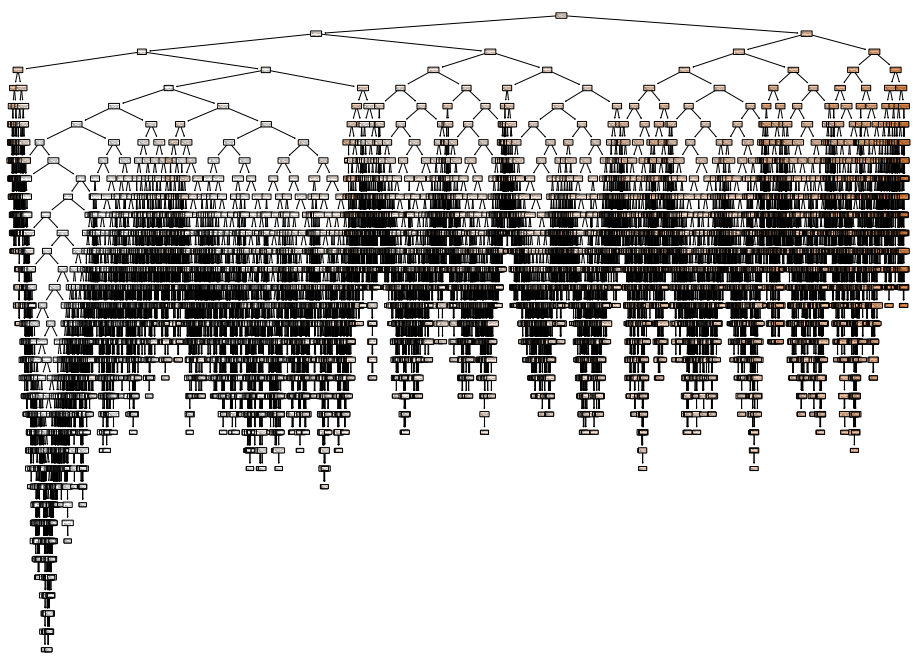

In [252]:
### This will take a long time (10-20 minutes); skip if you are in a hurry
#let's plot what the tree looks like
plt.figure(figsize=(16,12))

plot_tree(dtmodel, feature_names=features, filled=True, label='all', rounded=True)

plt.show()

### [Task 4a] (10 points) Answer some questions about the structure of our tree (dtmodel)

#### 1. Can the tree be visualized easily?
#### 2. How deep is the tree?
#### 3. How many nodes it contain?
#### 4. How many total splits are there?
#### 5. What is the impurity of the last 2 nodes?
#### Hint: lookup the scikit-learn documentation to know how to manipulate the 'tree_' attribute of Decision Trees.

In [253]:
###* put your answer as comment here *###
# 1. No, the tree cannot be visualized easily.
print(dtmodel.tree_.max_depth)
# 2. The depth of the tree is 35.
print(dtmodel.tree_.node_count)
# 3. The number of nodes is 18157
print(dtmodel.tree_.node_count-dtmodel.tree_.n_leaves)
# 4. The number of split nodes is 9078
print(dtmodel.tree_.impurity[-1])
print(dtmodel.tree_.impurity[-2])
# 5. The impurity of last two nodes is 0

35
18157
9078
0.0
0.0


#### Let's evaluate the decision tree model.

In [254]:
r2_mse_mae_eval(dtmodel)

Train R^2: 1.000, Val  R^2: 0.968
Train MSE: 0.000, Val MSE: 1076.791
Train MAE: 0.000, Val MAE: 10.691


### [Task 4b] (5 points) Is it a good model? Is it overfitted? Is it better than the models trained in Tasks 2 and 3? (A few sentences suffice.)

In [255]:
###* put your answer as comment here *###
# No the model is is not good as it is clearly overfitting, as the train mse and mae are 0 whereas the validation mse and mae 
# are quite high. Yes, the models trained in task 2 and 3 are better.
#
#

### [Task 4c] (5 points) Train another decision tree but this time regularize it. Can you obtain a model with similar performance to 'dtmodel' but not (or at least less) overfitted? 

In [256]:
### Call your new model 'dtregmodel'
###* put your code here *###
dtregmodel= DecisionTreeRegressor(max_depth=15,min_samples_split=1000,random_state=seed).fit(train_x, train_y)

r2_mse_mae_eval(dtregmodel)

Train R^2: 0.883, Val  R^2: 0.878
Train MSE: 3848.242, Val MSE: 4057.548
Train MAE: 34.147, Val MAE: 34.299


### [Task 4d] (5 points) Now let's train a random forest and see if we can train an even better model. Use search_train_eval() to do a grid search over hyperparameters. You are free to pick whatever hyperparameters & values you want, but you should try to avoid badly overfitting.

In [257]:
from sklearn.ensemble import RandomForestRegressor

### Call your random forest model 'rfmodel'
### Make sure to set random_state=seed for reproducibility!
###* put your code here *###
param_grid={'n_estimators':[100,200,300],'max_depth':[10,15,20,25],'min_samples_split':[100,250,500,750,1000]}
model=RandomForestRegressor(random_state=seed)
rfmodel=search_train_eval(model,param_grid,train_x,train_y,val_x,val_y)

RandomForestRegressor({'max_depth': 20, 'min_samples_split': 100, 'n_estimators': 300})
	Train R^2: 0.965, Val  R^2: 0.959
	Train MSE: 1144.541, Val MSE: 1372.037
	Train MAE: 12.961, Val MAE: 13.737


### [Task 4e] (5 points) Is your RF model better than the decision tree you trained for Task 4c? Justify your answer. What can you conclude about ensembles/random forests?

In [259]:
###* put your answer as comment here *###
# Yes, the RF model is better than the decision tree trained in Task 4c. The train and validation mse and mae scores are 
# much lower and r2 is higher when compared to decision tree. So, the ensembles/ random forests generally have better performance as it 
# trains multiple weak models inorder to gain knowledge and combines the results to get a much better model than standalone
# models.

## [CIS6930 Additional Task -- Task 5] (25 points): Stacking Meta Model

### For this task we'll use stacking to create a meta model or blender model to predict the target using predictions from 6 other models from Tasks 1 - 4 as features!

### [Task 5a] (10 points) Fill in the code below.

In [260]:
from sklearn.preprocessing import StandardScaler
    
# these are the models we'll use from previous tasks
# (this is why it's important that you named the models as instructed in Tasks 2-4)
regressors = [('lr', lrmodel), ('elasticnet', enmodel), ('ridge', rmodel), 
             ('dt', dtmodel), ('dtreg', dtregmodel), ('rf', rfmodel)]

# this will return predictions for all of our regressors on matrix x
def regressors_preds(x):
    num_regs = len(regressors)
    
    ### Create an array to contain the predictions from the regressors over all examples in 'x'
    ### Each regressor will correspond to one feature (i.e., one column)
    ### The numpy array you return should have shape (x.shape[0], num_regs)
    ###* put your code here (~4-6 lines) *###
    return np.column_stack((lrmodel.predict(x),enmodel.predict(x),rmodel.predict(x),dtmodel.predict(x),dtregmodel.predict(x),rfmodel.predict(x)))
    

def stacking_train_eval(model_name, model, standardize=False):
    ### Create a new training dataset 'meta_train_x' and 'meta_train_y'
    ### For this use the validation data (val_x, val_y) alongside with regressors_preds()
    ###* put your code here (~2 lines) *###
    
    meta_train_x=regressors_preds(val_x)
    meta_train_y=val_y
    assert meta_train_x.shape == (2606, 6) and meta_train_x.shape[0] == meta_train_y.shape[0]


    ### Create our new test dataset 'meta_test_x' and 'meta_test_y'
    ### For this we use the test data (test_x, test_y) alongside with regressors_preds()
    ###* put your code here (~2 lines) *###

    meta_test_x=regressors_preds(test_x)
    meta_test_y=test_y
    
    assert meta_test_x.shape == (2607, 6) and meta_test_x.shape[0] == meta_test_y.shape[0]
    
    # zscore normalize the features if standardize = True
    if standardize:
        scaler = StandardScaler()
        meta_train_x = scaler.fit_transform(meta_train_x)
        meta_test_x = scaler.transform(meta_test_x)

    
    # train the meta model
    model.fit(meta_train_x, meta_train_y)

    # make predictions & eval
    train_pred = model.predict(meta_train_x)
    test_pred = model.predict(meta_test_x)

    train_error = mean_squared_error(train_pred, meta_train_y)
    val_error = mean_squared_error(test_pred, test_y)

    print('Stacking (Meta model: {})'.format(model_name))
    print('\tTrain MSE: {:.3f}, Test MSE: {:.3f}'.format(train_error, val_error))

    train_error = mean_absolute_error(train_pred, meta_train_y)
    val_error = mean_absolute_error(test_pred, test_y)

    print('\tTrain MAE: {:.3f}, Test MAE: {:.3f}'.format(train_error, val_error))

### [Task 5b] (3 points) Train a SVM regression model with a linear kernel and C=100. Use stacking_train_eval(). You can set standardize=True to zscore normalize features.)

In [261]:
### Train a SVM regressor with a linear kernel and C=100
### Note: the training will take a few minutes
###* put your code here (~2-3 lines) *###
from sklearn.svm import SVR
model=SVR(kernel='linear',C=100)
stacking_train_eval("Linear SVR",model,standardize=True)



Stacking (Meta model: Linear SVR)
	Train MSE: 880.011, Test MSE: 1184.046
	Train MAE: 10.047, Test MAE: 10.442


### [Task 5c] (2 points) How good is this model? (A few sentences suffice.)

In [262]:
###* put your answer as comment here *###
#  The mse, mae train and test scores are relatively low when compared to standalone models. So this blender model is doing 
#  fine and be improved when given more data or with improved hyperparameters.
#

### [Task 5d] (5 points) Now train a SVM regression model with any other kernel (i.e., not linear) and combination of hyperparameters of your choice. Can you train a better stacking model than for Task 5b?

In [263]:
### Train a SVM regressor with any non-linear kernel and hyperparameters you want 
### You can do a hyperparameter search if you want
###* put your code here (~2-3 lines) *###
from sklearn.svm import SVR
model=SVR(kernel='sigmoid',C=50,coef0=0.5)
stacking_train_eval("Sigmoid SVR",model,standardize=True)



Stacking (Meta model: Sigmoid SVR)
	Train MSE: 45352149.838, Test MSE: 45334378.642
	Train MAE: 5353.116, Test MAE: 5340.338


### [Task 5e] (5 points) What do you conclude? Provide a plausible explanation why non-linear kernels do not seem to improve the result.

In [264]:
###* put your answer as comment here *###
# After trying various combinations of non linear models and their respective hyperparameters, the non linear kernels do
#  not seem to improve the result rather they make things worse. This may be due to the fact after all models in the blender predicting the target values
#  the data is mostly linear and having the data transform into another forms respective to kernels makes it no good and 
# hence worse results.